# Análisis de datos para la creación del modelo predictivo de diagnóstico de enfermedades cardiovasculares

Pimero iniciaremos la exploración de este [conjunto de datos](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) proporcionado por el usuario de [Kaggle](https://www.kaggle.com/) [sulianova](https://www.kaggle.com/sulianova). Este conjunto de datos consiste en un total de 70,000 registros de pacientes, presentando 11 características y una característica objetivo. Todos los registros fueron recolectados durante exámenes médicos.

## Descripción de los datos

Hay 3 tipos diferentes de características de entrada:
* Objetiva: información objetiva.
* Revisión: resultados de una revisión médica.
* Subjetiva: información dada por el paciente.

### Características:
|Característica|Tipo de Característica|Nombre en el Dataset|Unidad|
|:-------------|:---------------------|:-------------------|:----:|
|Edad  | Objetiva | age    | int (días)|
|Peso  | Objetiva | height | int (cm) |
|Talla | Objetiva | weight | float (kg) |
|Sexo  | Objetiva | gender | 1: mujer, 2: hombre |
|Presión Arterial Sistólica | Revisión | ap_hi | int (mmHg)|
|Presión Arterial Diastólica| Revisión | ap_lo | int (mmHg)|
|Colesterol | Revisión | cholesterol | 1: normal, 2: arriba de lo normal, 3: muy arriba de lo normal |
|Glucosa    | Revisión | gluc | 1: normal, 2: arriba de lo normal, 3: muy arriba de lo normal |
|Fumador | Subjetiva | smoke | binario |
|Consumo de Alcohol | Subjetiva | alco | binario |
|Actividad Física | Subjetiva | active | binario |
|Presencia o ausencia de una Enfermedad Cardiovacular | Variable objetivo | cardio | binario |

In [1]:
# importando librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

# importando el dataset
# en este caso el caracter que delimita es ';' y no ','
data = pd.read_csv("cardio_train.csv", delimiter = ';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [2]:
# La edad esta dada en dia, la transformaremos a años para un mejor entendimiento
data['age'] = data['age']/365

# De igual manera nos es mas facil ver la talla como metros en vez de cm
data['height'] = data['height']/100

# Mas delante vamos a comprobar el impacto que tiene para el entrenamiento quitar los campos de peso y talla
# y en su lugar solo tomar en cuenta el indice de masa corporal (IMC=peso(kg)/(talla(m))^2)
data['imc'] = data['weight'] / data['height']**2

data.head().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc
0,0,50.39,2,1.68,62.0,110,80,1,1,0,0,1,0,21.97
1,1,55.42,1,1.56,85.0,140,90,3,1,0,0,1,1,34.93
2,2,51.66,1,1.65,64.0,130,70,3,1,0,0,0,1,23.51
3,3,48.28,2,1.69,82.0,150,100,1,1,0,0,1,1,28.71
4,4,47.87,1,1.56,56.0,100,60,1,1,0,0,0,0,23.01


In [3]:
# Identificando la presencia de valores nulos o dublicados.
data.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
imc            0
dtype: int64

In [4]:
duplicados = len(data) - len(data.drop(['id'],axis=1).drop_duplicates())
data.drop(['id'],axis=1,inplace=True)
data.drop_duplicates(inplace=True)
print("{0} campos duplicados borrados, nuevas dimensiones del dataset = {1}".format(duplicados,data.shape))

24 campos duplicados borrados, nuevas dimensiones del dataset = (69976, 13)


In [5]:
# Ahora con los datos un poco mas limpios podemos ver un resumen rapido de las caracteristicas
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,69976.0,53.34,6.76,29.58,48.39,53.98,58.43,64.97
gender,69976.0,1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,69976.0,1.64,0.08,0.55,1.59,1.65,1.70,2.50
weight,69976.0,74.21,14.40,10.00,65.00,72.00,82.00,200.00
ap_hi,69976.0,128.82,154.04,-150.00,120.00,120.00,140.00,16020.00
ap_lo,69976.0,96.64,188.50,-70.00,80.00,80.00,90.00,11000.00
cholesterol,69976.0,1.37,0.68,1.00,1.00,1.00,2.00,3.00
gluc,69976.0,1.23,0.57,1.00,1.00,1.00,1.00,3.00
smoke,69976.0,0.09,0.28,0.00,0.00,0.00,0.00,1.00
alco,69976.0,0.05,0.23,0.00,0.00,0.00,0.00,1.00


In [39]:
m = len(data['gender'][data['gender']==1])
h = len(data['gender'][data['gender']==2])
print("mujeres={0}, hombres={1}, total={2}".format(m,h,h+m))

mujeres=45509, hombres=24467, total=69976


De este resumen notamos que 
1. La distribución de personas enfermas con sanas es bastante balanceada
2. En este conjunto de datos hay mas mujeres que hombres
3. 

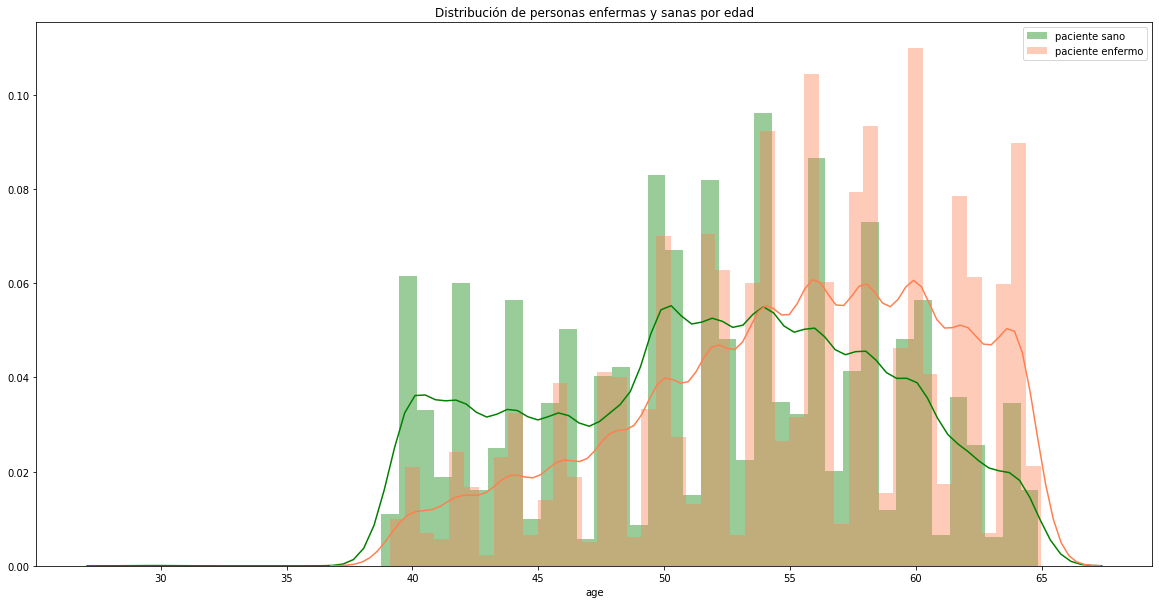

In [43]:
fig, ax1 = plt.subplots(1,figsize=(20,10))

# Sin problemas cardiovasculares
sns.distplot(data['age'][data['cardio']==0], ax = ax1, color='green', label = 'paciente sano')
# Con problemas cardiovasculares
sns.distplot(data['age'][data['cardio']==1], ax = ax1, color='coral', label = 'paciente enfermo')

ax1.set_title('Distribución de personas enfermas y sanas por edad')
ax1.legend()
plt.show()

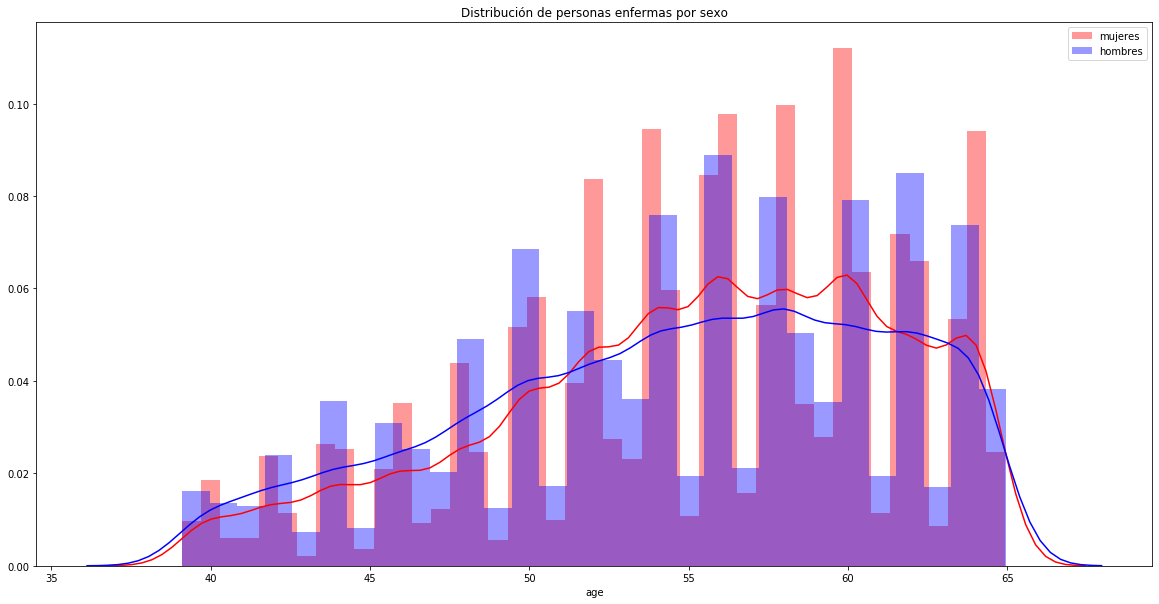

In [27]:
fig, ax2 = plt.subplots(1,figsize=(20,10))

# Hombres enfermos
sns.distplot(data['age'][(data['gender']==1) & (data['cardio']==1)],ax = ax2,color='red', label ='mujeres')

# Mujeres enfermas
sns.distplot(data['age'][(data['gender']==2) & (data['cardio']==1)],ax = ax2,color='blue', label = 'hombres')

ax2.set_title('Distribución de personas enfermas por sexo')
ax2.legend()
plt.show()